# Convex Minimization Timing

This notbook is used to time how long it takes to run the solver for the optimization problem, using DCP and DPP.

In [1]:
import numpy as np
import cvxpy as cp
import time
import matplotlib.pyplot as plt

In [2]:
times_dcp = np.zeros(10)
times_dpp = np.zeros(10)

In [70]:
# Setup
ACT_DIM = 10  # action space dimensions
ETA = 1e-8  # used to enforce strict inequality

alpha = cp.Parameter()  # (> 1) constraint on maximum policy ratio

# safe policy (cvxpy parameters)
mu_safe = cp.Parameter(ACT_DIM)
sigma_safe = cp.Parameter(ACT_DIM, pos=True)

# task policy (cvxpy parameters)
mu_task = cp.Parameter(ACT_DIM)
sigma_task = cp.Parameter(ACT_DIM, pos=True)

# projected policy (cvxpy variables)
mu_proj = cp.Variable(ACT_DIM)
sigma_proj = cp.Variable(ACT_DIM, pos=True)


# Additional variables/parameters for DPP
# safe policy (cvxpy parameters)
sigma_safe_inv = cp.Parameter(ACT_DIM, pos=True)  # 1/sigma_safe
sigma_sigma_safe = cp.Parameter(ACT_DIM, pos=True)  # sigma_safe^2

# task policy (cvxpy parameters)
sigma_task_inv = cp.Parameter(ACT_DIM, pos=True)  # 1/sigma_task
mu_sigma_task = cp.Parameter(ACT_DIM)  # mu_task/sigma_task
mu_sigma_sigma_task = cp.Parameter(ACT_DIM)  # mu_task/(sigma_task)^2

# sum term (cvxpy variables)
mu_safe_var = cp.Variable(ACT_DIM)  # mu_safe
sigma_sigma_safe_var = cp.Variable(ACT_DIM, pos=True)  # sigma_safe^2

In [71]:
# Problem definition
objective_dcp = cp.Minimize(
    -2 * cp.sum(cp.log(sigma_proj))
    + cp.sum_squares(sigma_proj / sigma_task)
    + cp.sum_squares((mu_proj - mu_task) / sigma_task)
)

constraints_dcp = []

constraint_1_dcp = sigma_proj + ETA <= sigma_safe
constraints_dcp.append(constraint_1_dcp)

sum_term_dcp = 0  # we define the sum term like this so that we can use quad_over_lin and thus allow the problem to be DCP (standard quotient operator is not DCP)
for i in range(0, ACT_DIM):
    sum_term_dcp += cp.quad_over_lin(
        mu_proj[i] - mu_safe[i], cp.square(sigma_safe[i]) - cp.square(sigma_proj[i])
    )  # note that numerator gets squared (which we want)

constraint_2_dcp = cp.sum(cp.log(sigma_safe)) - cp.sum(cp.log(sigma_proj)) + (
    1 / 2
) * sum_term_dcp <= cp.log(alpha)
constraints_dcp.append(constraint_2_dcp)

prob_dcp = cp.Problem(objective_dcp, constraints_dcp)

In [72]:
# Problem re-definition as DPP
objective_dpp = cp.Minimize(
    -2 * cp.sum(cp.log(sigma_proj))
    + cp.sum_squares(cp.multiply(sigma_proj, sigma_task_inv))
    + cp.sum_squares(cp.multiply(mu_proj, sigma_task_inv))
    - 2 * cp.sum(cp.multiply(mu_proj, mu_sigma_sigma_task))
    + cp.sum_squares(mu_sigma_task)
)

constraints_dpp = []

constraint_1_dpp = sigma_proj + ETA <= sigma_safe
constraints_dpp.append(constraint_1_dpp)

sum_term_dpp = 0  # we define the sum term like this so that we can use quad_over_lin and thus allow the problem to be DCP (standard quotient operator is not DCP)
for i in range(0, ACT_DIM):
    sum_term_dpp += cp.quad_over_lin(
        mu_proj[i] - mu_safe_var[i], sigma_sigma_safe_var[i] - cp.square(sigma_proj[i])
    )  # note that numerator gets squared (which we want)

constraint_2_dpp = -cp.sum(cp.log(sigma_safe_inv)) - cp.sum(cp.log(sigma_proj)) + (
    1 / 2
) * sum_term_dpp <= cp.log(alpha)
constraints_dpp.append(constraint_2_dpp)

constraint_3_dpp = mu_safe_var == mu_safe
constraints_dpp.append(constraint_3_dpp)

constraint_4_dpp = sigma_sigma_safe_var == sigma_sigma_safe
constraints_dpp.append(constraint_4_dpp)

prob_dpp = cp.Problem(objective_dpp, constraints_dpp)

In [73]:
# Generate examples
alpha.value = 1.1  # (> 1) constraint on maximum policy ratio

STRAY_FACTOR = 0.05  # factor on how far the task policy strays from the safe policy

N = 1000  # no. examples

mu_safe_list = []
sigma_safe_list = []

mu_task_list = []
sigma_task_list = []

sigma_safe_inv_list = []
sigma_sigma_safe_list = []

sigma_task_inv_list = []
mu_sigma_task_list = []
mu_sigma_sigma_task_list = []

for i in range(0, N):
    # safe policy
    mu_safe_list.append(np.random.randn(ACT_DIM))
    sigma_safe_list.append(np.random.rayleigh(scale=0.5, size=ACT_DIM))  # > 0

    # task policy
    mu_task_list.append(
        mu_safe_list[i] + STRAY_FACTOR * np.random.randn(ACT_DIM)
    )  # put task policy mean somewhere fairly close to safe policy mean
    sigma_task_list.append(
        sigma_safe_list[i]
        - np.minimum(
            STRAY_FACTOR
            * sigma_safe_list[i]
            * np.random.rayleigh(scale=0.5, size=ACT_DIM),
            sigma_safe_list[i] - ETA,
        )
    )  # put task policy stdev somewhere fairly close to but less than safe policy stdev (and > 0)

    # Set additional DPP parameters for examples

    sigma_safe_inv_list.append(1 / sigma_safe_list[i])  # 1/sigma_safe
    sigma_sigma_safe_list.append(np.square(sigma_safe_list[i]))  # sigma_safe^2

    # task policy (cvxpy parameters)
    sigma_task_inv_list.append(1 / sigma_task_list[i])  # 1/sigma_task
    mu_sigma_task_list.append(
        mu_task_list[i] / sigma_task_list[i]
    )  # mu_task/sigma_task
    mu_sigma_sigma_task_list.append(
        mu_task_list[i] / np.square(sigma_task_list[i])
    )  # mu_task/(sigma_task)^2

In [74]:
# Time DCP

t0_dcp = time.time()
for i in range(0, N):
    mu_safe.value = mu_safe_list[i]
    sigma_safe.value = sigma_safe_list[i]

    mu_task.value = mu_task_list[i]
    sigma_task.value = sigma_task_list[i]

    sigma_safe_inv.value = sigma_safe_inv_list[i]
    sigma_sigma_safe.value = sigma_sigma_safe_list[i]

    sigma_task_inv.value = sigma_task_inv_list[i]
    mu_sigma_task.value = mu_sigma_task_list[i]
    mu_sigma_sigma_task.value = mu_sigma_sigma_task_list[i]

    # warm start as safe policy
    # bad idea since sigma_proj = sigma_safe messes things up
    # mu_proj.value = mu_safe_list[i]
    # sigma_proj.value = sigma_safe_list[i]
    # mu_safe_var.value = mu_safe_list[i]
    # sigma_sigma_safe_var.value = np.square(sigma_safe_list[i])

    result = prob_dcp.solve()
    # result = prob_dcp.solve(warm_start=True)
t1_dcp = time.time()

time_avg_dcp = (t1_dcp - t0_dcp) / N
print((time_avg_dcp))

times_dcp[ACT_DIM - 1] = time_avg_dcp
# times_dcp = np.append(times_dcp,time_avg_dcp)

0.02306832814216614


In [75]:
# Time DPP

t0_dpp = time.time()
for i in range(0, N):
    mu_safe.value = mu_safe_list[i]
    sigma_safe.value = sigma_safe_list[i]

    mu_task.value = mu_task_list[i]
    sigma_task.value = sigma_task_list[i]

    sigma_safe_inv.value = sigma_safe_inv_list[i]
    sigma_sigma_safe.value = sigma_sigma_safe_list[i]

    sigma_task_inv.value = sigma_task_inv_list[i]
    mu_sigma_task.value = mu_sigma_task_list[i]
    mu_sigma_sigma_task.value = mu_sigma_sigma_task_list[i]

    # warm start as safe policy
    # bad idea since sigma_proj = sigma_safe messes things up
    # mu_proj.value = mu_safe_list[i]
    # sigma_proj.value = sigma_safe_list[i]
    # mu_safe_var.value = mu_safe_list[i]
    # sigma_sigma_safe_var.value = np.square(sigma_safe_list[i])

    result = prob_dpp.solve()
    # result = prob_dpp.solve(warm_start=True)
t1_dpp = time.time()

time_avg_dpp = (t1_dpp - t0_dpp) / N
print((time_avg_dpp))

times_dpp[ACT_DIM - 1] = time_avg_dpp
# times_dpp = np.append(times_dpp,time_avg_dpp)

0.0019739484786987305


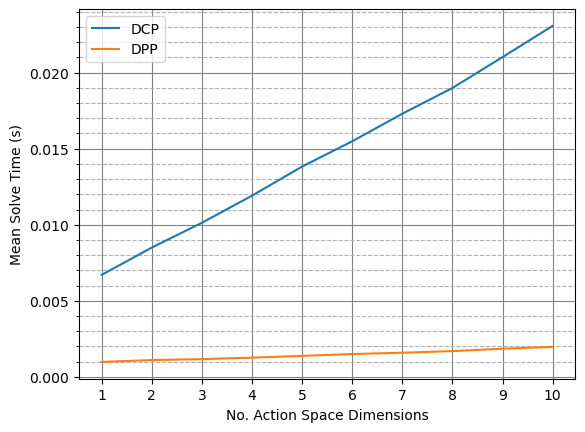

In [76]:
n = np.arange(1, 11)
plt.minorticks_on()
plt.plot(n, times_dcp, label="DCP")
plt.plot(n, times_dpp, label="DPP")
plt.legend()
plt.xlabel("No. Action Space Dimensions")
plt.ylabel("Mean Solve Time (s)")
plt.grid(which="minor", axis="y", linestyle="--")
plt.grid(which="major", linestyle="-", color="gray")
plt.xticks(np.arange(min(n), max(n) + 1, 1.0))
plt.tick_params(which="minor", bottom=False)
# plt.show()
plt.savefig("solve_times.svg")

In [77]:
# Check solutions are still sensible for high no. action space dimensions
print(mu_safe.value)
print(mu_proj.value)
print(mu_task.value)

print(sigma_safe.value)
print(sigma_proj.value)
print(sigma_task.value)

[ 0.90060348 -2.05490063 -0.6756943  -0.16906133 -0.23970326  0.21848303
 -0.4260743  -1.17072643 -1.80228235 -1.86725577]
[ 0.91606594 -2.0549006  -0.6756943  -0.1690613  -0.22083038  0.21848303
 -0.42607429 -1.17072643 -1.82634333 -1.86725576]
[ 0.97784789 -2.02618592 -0.68853897 -0.12331591 -0.13705296  0.20858601
 -0.40007106 -1.1517241  -1.90247673 -1.84073934]
[0.56536078 0.34125283 0.4838813  0.72449219 0.74358109 0.99482579
 0.92662225 0.95712219 0.58747237 0.6153246 ]
[0.5561186  0.34125281 0.48388129 0.72449216 0.73256516 0.99482577
 0.92662221 0.95712217 0.57505291 0.61532459]
[0.54441409 0.33912475 0.48254541 0.70271965 0.71880337 0.97631695
 0.88955502 0.93455699 0.5718233  0.59874865]
